# Positive-unlabelled learning for prioritising variants post-GWAS - test run
- Blood pressure GWAS variants annotated previously entering machine learning to prioritise most likely blood pressure variants
- Positive-unlabelled learning involves labelling only positive examples (I currently label variants as positive depending on if they match pathogenic criteria for BP in ClinVar)
- I use bagging positive-unlabelled learning, so the training data consists of all positive examples and a equally sized bootstrapped sample of other variants.
- The model (xgboost in this script) is a binary classifier that will train on this subsample of positives and unlabelled sampels that it perceives as 'negatives'
- The trained model then predicts probabilities for all other variants
- Currently I run 15 iterations of this, taking the average probability per variant as its prediction

In [1]:
# import libraries:

import re
import time
import warnings

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from pulearn import BaggingPuClassifier, ElkanotoPuClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

seed = 42

In [2]:
# import data that was previously annotated using hail in the Google Cloud Platform
pd_table = pd.read_csv("BP_GWAS_data.csv")

In [3]:
pd_table

,CP,Gene,diagnosis,star,pathogenicity,DANN.score,CADD.raw_score,CADD.PHRED_score,gerp_scores.N,BETAsbp,...,Skin_Not_Sun_Exposed_Suprapubic,Small_Intestine_Terminal_Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole_Blood,BPlabel
0,10:102075479,PKD2L1,NaN,NaN,NaN,NaN,NaN,NaN,2.510,0.2330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,10:102552663,PAX2,NaN,NaN,NaN,NaN,NaN,NaN,6.040,0.6868,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,10:102552752,PAX2,NaN,NaN,NaN,NaN,NaN,NaN,6.080,0.6877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,10:102553647,PAX2,NaN,NaN,NaN,NaN,NaN,NaN,4.120,0.6846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,10:102554618,PAX2,NaN,NaN,NaN,NaN,1.027054,13.610,3.930,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42777,9:95323297,CENPP,NaN,NaN,NaN,0.440855,0.081993,3.960,2.020,0.1629,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
42778,9:95336327,CENPP,NaN,NaN,NaN,0.446531,-0.035967,2.117,NaN,0.1626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
42779,9:95337520,CENPP,NaN,NaN,NaN,NaN,NaN,NaN,0.128,-0.1630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
42780,9:96176203,Y_RNA,NaN,NaN,NaN,0.514746,-0.065587,1.759,NaN,-0.1135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [4]:
features = pd_table.drop(["Gene", "CP", "BPlabel"], axis=1)

In [5]:
# converting labels from True/False to binary numeric values for machine learning
features["BPlabel"] = np.where(pd_table["BPlabel"] == True, 1, 0)
correlated_features = set()
correlation_matrix = features.corr()

In [6]:
# identifying highly correlated features to remove before machine learning
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [7]:
print(correlated_features)

{'CADD.PHRED_score', 'SiPhy_29way_logOdds', 'Pituitary', 'integrated_fitCons', 'Brain_Substantia_nigra', 'Vagina', 'Heart_Atrial_Appendage', 'Small_Intestine_Terminal_Ileum', 'Spleen', 'Brain_Anterior_cingulate_cortex_BA24', 'Kidney_Cortex', 'Uterus', 'Whole_Blood', 'Brain_Caudate_basal_ganglia', 'sift_pred', 'Minor_Salivary_Gland', 'bStatistic', 'BETApp', 'Muscle_Skeletal'}


In [8]:
# removing correlated features and imputing missing features
pd_table["Y"] = np.where(pd_table["BPlabel"] == True, 1, 0)
Y = pd_table["Y"]
X = pd_table.drop(
    ["BPlabel", "Gene", "CP", "diagnosis", "star", "pathogenicity", "Y"], axis=1
)

X.drop(labels=correlated_features, axis=1, inplace=True)
imputer = SimpleImputer(strategy="median", missing_values=np.nan)
X = pd.DataFrame(imputer.fit_transform(X), index=X.index, columns=X.columns)

In [9]:
# running positive-unlabelled machine learning with PULearn package
model = XGBClassifier(
    objective="binary:logistic", eval_metric="logloss", use_label_encoder=False
)
pu_estimator = BaggingPuClassifier(base_estimator=model, n_estimators=15)
pu_estimator.fit(X, Y)

y_pred = pu_estimator.predict_proba(X)

In [10]:
# investigating performance on positive predictions only
y_pred = y_pred[:, 1]
y_predict = [1 if x > 0.5 else 0 for x in y_pred]
y_positive = Y == 1

print("Classification results:")
acc = accuracy_score(y_positive, y_predict)
print("accuracy: %.2f%%" % (acc * 100.0))
f1 = f1_score(y_positive, y_predict)
print("f1: %.2f%%" % (f1 * 100.0))
roc = roc_auc_score(y_positive, y_predict)
print("roc: %.2f%%" % (roc * 100.0))
rec = recall_score(y_positive, y_predict, average="binary")
print("recall: %.2f%%" % (rec * 100.0))
prc = precision_score(y_positive, y_predict, average="binary")
print("precision: %.2f%%" % (prc * 100.0))

Classification results:
accuracy: 99.81%
f1: 93.52%
roc: 95.42%
recall: 90.90%
precision: 96.30%


In [11]:
X["Y"] = pd_table["Y"]
X_pos = X[Y == 1]
X_pos = X_pos.drop(["Y"], axis=1)
X = X.drop(["Y"], axis=1)

In [12]:
y_pred_pos = pu_estimator.predict_proba(X_pos)
y_pred_pos = y_pred_pos[:, 1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]
y_pos = list(y_positive)

In [13]:
def estimator_predict(data_asarray):
    data_asframe = pd.DataFrame(data_asarray, columns=X_pos.columns)
    return pu_estimator.predict(data_asframe)

In [14]:
# Shap interpretation (needing their KernelExplainer so it accepts the PUlearn package)
X_pos_summary = shap.kmeans(X_pos, 10)
ex = shap.KernelExplainer(estimator_predict, X_pos_summary)

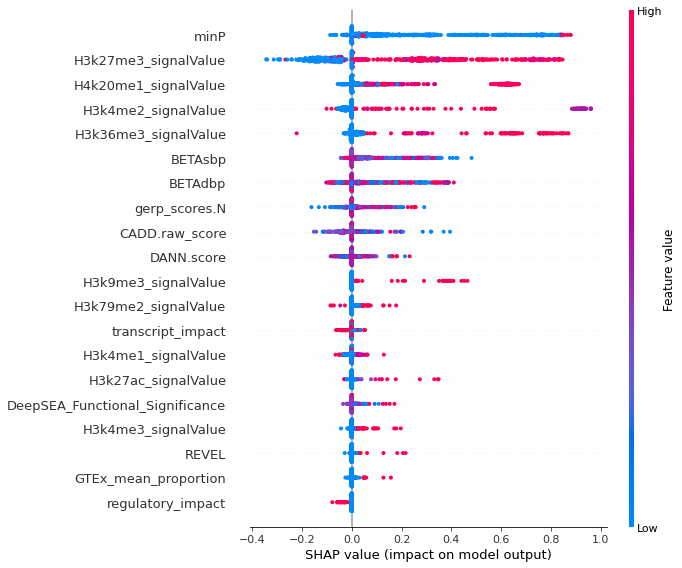

In [15]:
shap_values = ex.shap_values(X_pos)

fig, ax = plt.subplots()
shap.summary_plot(shap_values, X_pos)

In [16]:
expected_value = ex.expected_value

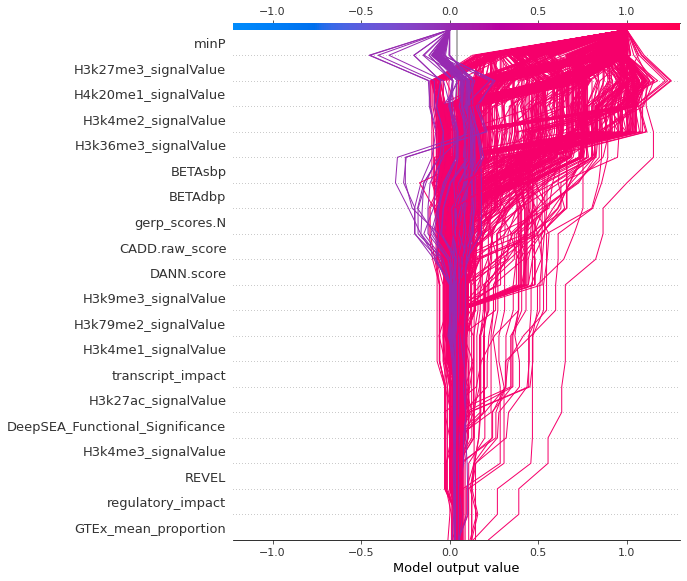

In [17]:
fig, ax = plt.subplots()
shap.decision_plot(
    expected_value, ex.shap_values(X_pos), list(X_pos), ignore_warnings=True,
)

In [18]:
pd.set_option("display.float_format", str)
y_pred = pu_estimator.predict_proba(X)
y_pred = y_pred[:, 1]
output = pd.Series(data=y_pred, name="XGB_Prob")

locus = pd_table[["Gene", "CP", "BPlabel"]]

df = pd.concat([locus, output], axis=1)
df = df.sort_values(by=["XGB_Prob"], ascending=False)

In [19]:
df.head(10)

,Gene,CP,BPlabel,XGB_Prob
34989,NPR3,5:32691144,1,0.9986500024795533
5621,CCND1,11:69452709,1,0.9983906507492065
34990,NPR3,5:32691416,1,0.9983647108078003
15293,NEDD4L,18:55720220,1,0.9983232696851094
15296,NEDD4L,18:55720731,1,0.9981707255045573
34995,NPR3,5:32693566,1,0.998013174533844
34988,NPR3,5:32690413,1,0.9980018099149068
34992,NPR3,5:32692536,1,0.9976106961568196
34999,NPR3,5:32694033,1,0.9976106961568196
30186,CACNA2D2,3:50431410,1,0.9975826303164165


In [25]:
# Trying a 'from scratch' machine learning approach not using PUlearn package
# Adding Y back into the data to be able to divide positives and unlabelled variants
X["Y"] = Y

In [26]:
# using Y to identify positive samples for train and test data
data_P = X[X.Y == 1]
data_P_test = data_P.sample(frac=0.2)

df_both = data_P.append(data_P_test)
data_P = df_both.drop_duplicates(keep=False)

data_U = X[X.Y == 0]
data_U_test = data_U.sample(207)

df_both = data_U.append(data_U_test)
data_U = df_both.drop_duplicates(keep=False)

df_test = data_P_test.append(data_U_test)

data_P_train = data_P
data_P = data_P.drop(["Y"], axis=1)
data_U = data_U.drop(["Y"], axis=1)

NP = data_P.shape[0]
NU = data_U.shape[0]

In [28]:
T = 1
K = NP
train_label = np.zeros(shape=(NP + K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
start = time.time()
for i in range(T):
    # Bootstrap resample
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    # Positive set + bootstrapped unlabeled set
    data_bootstrap = np.concatenate((data_P, data_U.iloc[bootstrap_sample, :]), axis=0)
    # Train model
    model = XGBClassifier(objective="binary:logistic", eval_metric="logloss")

    model.fit(data_bootstrap, train_label)
    # Index for the out of the bag (oob) samples
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    f_oob[idx_oob] += model.predict_proba(data_U.iloc[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1] / n_oob

end = time.time()
print("Model fitting seconds:", (end - start))

Model fitting seconds: 0.17182397842407227


In [29]:
# Viewing model performance on predicting only positives for all the training data
data_pos = data_P_train
y_pos = data_pos["Y"]
data_pos = data_pos.drop(["Y"], axis=1)

y_pred_pos = model.predict_proba(data_pos)
y_pred_pos = y_pred_pos[:, 1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]
y_pos = list(y_pos)

print("XGBoost Classification Results:")
acc = accuracy_score(y_pos, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0))
f1 = f1_score(y_pos, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))

XGBoost Classification Results:
Accuracy: 100.00%
F1 Score: 100.00%


In [30]:
# Viewing model performance on predicting only positives for test data
data_P_test_true = data_P_test.drop(["Y"], axis=1)

y_pos = data_P_test["Y"]
y_pos = list(y_pos)

y_pred_pos = model.predict_proba(data_P_test_true)
y_pred_pos = y_pred_pos[:, 1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print("XGBoost Classification Results:")
acc = accuracy_score(y_pos, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0))
f1 = f1_score(y_pos, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))

XGBoost Classification Results:
Accuracy: 89.39%
F1 Score: 94.40%


In [31]:
# Viewing model performance on predicting both positive and 'negative' [unlabelled] samples for test data
df_test_true = df_test.drop(["Y"], axis=1)

y_true = df_test["Y"]

y_pred_pos = model.predict_proba(df_test_true)
y_pred_pos = y_pred_pos[:, 1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print("XGBoost Classification Results:")
acc = accuracy_score(y_true, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0))
f1 = f1_score(y_true, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))

XGBoost Classification Results:
Accuracy: 88.20%
F1 Score: 85.51%


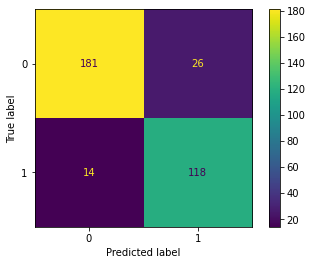

In [32]:
cm = confusion_matrix(y_true, y_predict_pos)

cm_display = ConfusionMatrixDisplay(cm).plot()

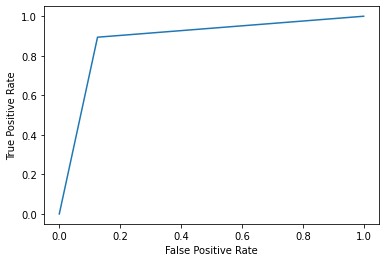

In [33]:
fpr, tpr, _ = roc_curve(y_true, y_predict_pos, pos_label=model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

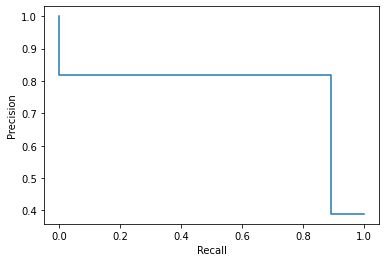

In [34]:
prec, recall, _ = precision_recall_curve(
    y_true, y_predict_pos, pos_label=model.classes_[1]
)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

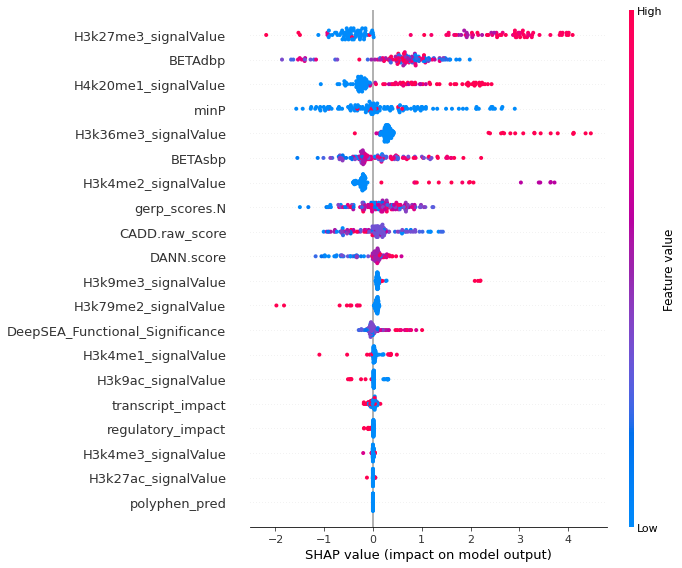

In [35]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_P_test_true)
shap.summary_plot(shap_values, data_P_test_true)

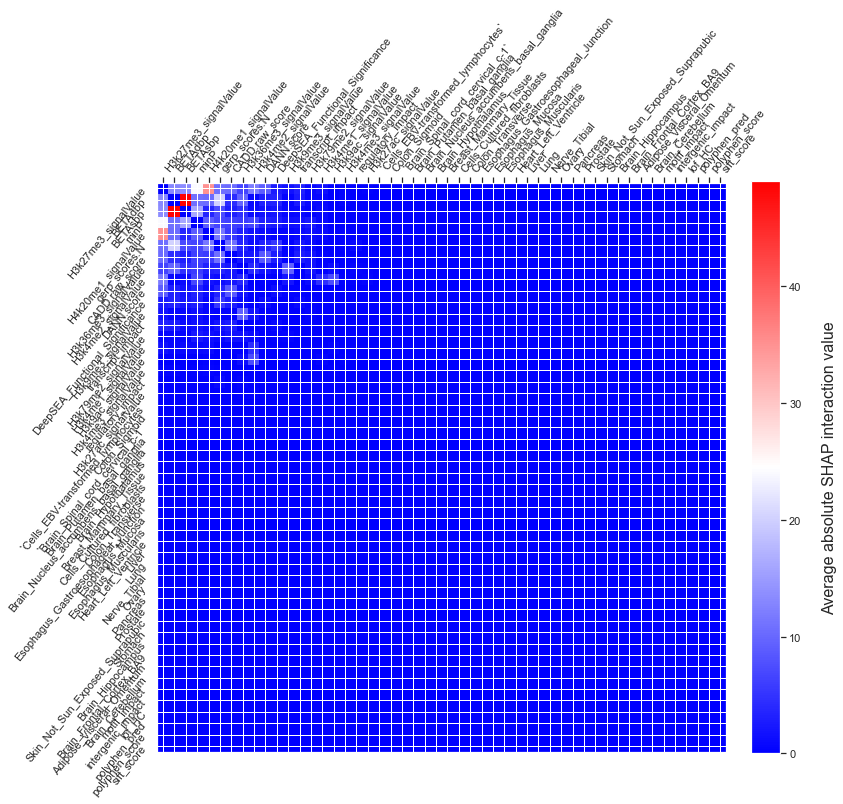

In [36]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(
    data_P_test_true
)

expected_value = explainer.expected_value

tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i, i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds, :][:, inds]

sns.set(font_scale=1)
f = plt.figure(figsize=(12, 12))
plt.imshow(
    tmp2, cmap="bwr"
)  # https://matplotlib.org/stable/gallery/color/colormap_reference.html
plt.yticks(
    range(tmp2.shape[0]),
    data_P_test_true.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
plt.xticks(
    range(tmp2.shape[0]),
    data_P_test_true.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label("Average absolute SHAP interaction value", size=16, labelpad=20)
plt.rcParams.update({"font.size": 16})
plt.tight_layout()

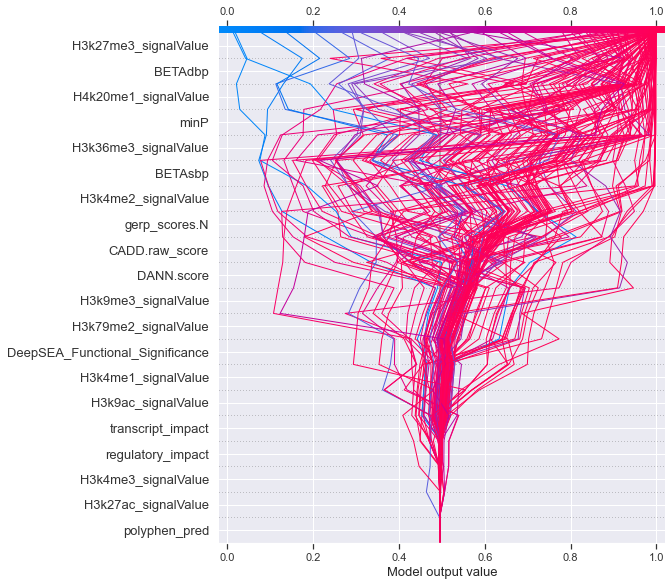

In [37]:
shap.decision_plot(expected_value, shap_values, list(data_P_test_true), link="logit")